DATA LOADING


In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('train1.csv')

print("Dataset shape:", df.shape)
print("\nTarget distribution:")
print(df['target'].value_counts(normalize=True))

# Detailed missing value analysis
missing_summary = df.isnull().sum()
missing_features = missing_summary[missing_summary > 0]
print(f"\nFeatures with missing values ({len(missing_features)}):")
for feature, missing_count in missing_features.items():
    missing_percent = (missing_count / len(df)) * 100
    print(f"{feature}: {missing_count} missing ({missing_percent:.2f}%)")

# Identify feature types
cat_features = [col for col in df.columns if '_cat' in col or '_bin' in col]
num_features = [col for col in df.columns if col not in cat_features + ['id', 'target']]

print(f"\nCategorical features: {len(cat_features)}")
print(f"Numerical features: {len(num_features)}")

Dataset shape: (296209, 67)

Target distribution:
target
0    0.948732
1    0.051268
Name: proportion, dtype: float64

Features with missing values (14):
ps_ind_02_cat: 125 missing (0.04%)
ps_ind_04_cat: 45 missing (0.02%)
ps_ind_05_cat: 2915 missing (0.98%)
ps_car_01_cat: 57 missing (0.02%)
ps_car_02_cat: 3 missing (0.00%)
ps_car_03_cat: 204589 missing (69.07%)
ps_car_05_cat: 132287 missing (44.66%)
ps_car_07_cat: 5783 missing (1.95%)
ps_car_09_cat: 288 missing (0.10%)
ps_reg_03: 53579 missing (18.09%)
ps_car_11: 4 missing (0.00%)
ps_car_12: 1 missing (0.00%)
ps_car_14: 21108 missing (7.13%)
feature4: 53579 missing (18.09%)

Categorical features: 31
Numerical features: 34


Train Validation Split


In [67]:
# Set random state using ERP ID
ERP_ID = 29005
np.random.seed(ERP_ID)

# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Split data
X_train, X_val, y_train, y_val = train_test_split(
X, y, test_size=0.3, random_state=ERP_ID, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Target distribution in training: {y_train.value_counts()}")
print(f"Target distribution in validation: {y_val.value_counts()}")

Training set: (207346, 66)
Validation set: (88863, 66)
Target distribution in training: target
0    196716
1     10630
Name: count, dtype: int64
Target distribution in validation: target
0    84307
1     4556
Name: count, dtype: int64


Data Preprocessing 

In [68]:
# Identify categorical and numerical features
cat_features = [col for col in X.columns if '_cat' in col or '_bin' in col]
num_features = [col for col in X.columns if col not in cat_features + ['id']]

print(f"Categorical features: {len(cat_features)}")
print(f"Numerical features: {len(num_features)}")

# Handle missing values
def preprocess_data(X_train, X_val):
    X_train_processed = X_train.copy()
    X_val_processed = X_val.copy()
    
    # For numerical features,impute with median
    num_imputer = SimpleImputer(strategy='median')
    X_train_processed[num_features] = num_imputer.fit_transform(X_train[num_features])
    X_val_processed[num_features] = num_imputer.transform(X_val[num_features])
    
    # For categorical features, impute with mode
    cat_imputer = SimpleImputer(strategy='most_frequent')
    X_train_processed[cat_features] = cat_imputer.fit_transform(X_train[cat_features])
    X_val_processed[cat_features] = cat_imputer.transform(X_val[cat_features])
    
    return X_train_processed, X_val_processed

X_train_processed, X_val_processed = preprocess_data(X_train, X_val)

Categorical features: 31
Numerical features: 34


Baseline Model with preprocessing

In [69]:
# Baseline Decision Tree
baseline_dt = DecisionTreeClassifier(random_state=ERP_ID)
baseline_dt.fit(X_train_processed.drop('id', axis=1), y_train)

# Predictions
y_pred_baseline = baseline_dt.predict_proba(X_val_processed.drop('id', axis=1))[:, 1]
baseline_auc = roc_auc_score(y_val, y_pred_baseline)

print(f"Baseline AUROC: {baseline_auc:.4f}")

Baseline AUROC: 0.5043


Features Selection using Anova and Chi sq(Anova for numerical vals and chi for categorical vals)

In [72]:
# Separate features for selection
X_train_features = X_train_processed.drop('id', axis=1)
X_val_features = X_val_processed.drop('id', axis=1)

# Identify categorical and numerical columns in processed data
cat_cols_processed = [col for col in X_train_features.columns if '_cat' in col or '_bin' in col]
num_cols_processed = [col for col in X_train_features.columns if col not in cat_cols_processed]

print(f"Processing {len(num_cols_processed)} numerical features and {len(cat_cols_processed)} categorical features")

# 1. ANOVA for numerical features
print("\n1. Selecting numerical features using ANOVA:")
anova_selector = SelectKBest(score_func=f_classif, k=20)
X_train_anova = anova_selector.fit_transform(X_train_features[num_cols_processed], y_train)
selected_num_features = [num_cols_processed[i] for i in anova_selector.get_support(indices=True)]
print(f"Selected {len(selected_num_features)} numerical features:")
print(selected_num_features)

# 2. Chi-square for categorical features
print("\n2. Selecting categorical features using Chi-square:")
chi2_selector = SelectKBest(score_func=chi2, k=10)
# Convert categorical features to ensure non-negative values
X_train_cat_nonneg = X_train_features[cat_cols_processed].apply(lambda x: x - x.min() if x.min() < 0 else x)
X_train_cat_nonneg = X_train_cat_nonneg.astype(np.int32)  # Convert to int32 for chi-square test
X_train_chi2 = chi2_selector.fit_transform(X_train_cat_nonneg, y_train)
selected_cat_features = [cat_cols_processed[i] for i in chi2_selector.get_support(indices=True)]
print(f"Selected {len(selected_cat_features)} categorical features:")
print(selected_cat_features)

# Combine selected features
selected_features = selected_num_features + selected_cat_features
print(f"\nTotal selected features: {len(selected_features)}")
print("Final feature set:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i}. {feature}")

Processing 34 numerical features and 31 categorical features

1. Selecting numerical features using ANOVA:
Selected 20 numerical features:
['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_14', 'feature2', 'feature3', 'feature4', 'feature5', 'feature7', 'feature8']

2. Selecting categorical features using Chi-square:
Selected 20 numerical features:
['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_14', 'feature2', 'feature3', 'feature4', 'feature5', 'feature7', 'feature8']

2. Selecting categorical features using Chi-square:
Selected 10 categorical features:
['ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_11_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_16_bin', 'ps_ind_17_bin']

T

wrapper methods

In [74]:
def evaluate_feature_set(features, X_train, X_val, y_train, y_val):

    if len(features) == 0:
        return 0.5  # Random guessing
    
    model = DecisionTreeClassifier(
        random_state=ERP_ID, 
        max_depth=3,  # Very shallow for speed
        min_samples_split=10
    )
    model.fit(X_train[features], y_train)
    y_pred = model.predict_proba(X_val[features])[:, 1]
    return roc_auc_score(y_val, y_pred)

# 1. MANUAL FORWARD SELECTION
print("1. MANUAL FORWARD SELECTION:")
current_features = []
remaining_features = selected_features.copy()  # Start with filtered features
best_score = 0.5

print("Adding features: ", end="")
for i in range(min(8, len(remaining_features))):  # Limit to 8 features max
    best_candidate = None
    best_candidate_score = 0
    
    for feature in remaining_features:
        candidate_features = current_features + [feature]
        score = evaluate_feature_set(candidate_features, X_train_features, X_val_features, y_train, y_val)
        
        if score > best_candidate_score:
            best_candidate_score = score
            best_candidate = feature
    
    if best_candidate and best_candidate_score > best_score:
        current_features.append(best_candidate)
        remaining_features.remove(best_candidate)
        best_score = best_candidate_score
        print(f"{best_candidate} ", end="")
    else:
        break  # Stop if no improvement

forward_features = current_features.copy()
print(f"\nForward selection: {len(forward_features)} features, AUROC: {best_score:.4f}")

# 2. MANUAL BACKWARD ELIMINATION  
print("\n2. MANUAL BACKWARD ELIMINATION:")
current_features = selected_features.copy()  # Start with all filtered features
baseline_score = evaluate_feature_set(current_features, X_train_features, X_val_features, y_train, y_val)

print(f"Starting with {len(current_features)} features, AUROC: {baseline_score:.4f}")
print("Removing features: ", end="")

# Remove features one by one if performance doesn't drop significantly
for feature in selected_features[:12]:  # Check first 12 features
    if feature not in current_features or len(current_features) <= 10:
        continue
        
    candidate_features = [f for f in current_features if f != feature]
    score = evaluate_feature_set(candidate_features, X_train_features, X_val_features, y_train, y_val)
    
    # Remove if performance doesn't drop more than 0.005
    if score >= baseline_score - 0.005:
        current_features.remove(feature)
        print(f"{feature} ", end="")
        baseline_score = score

backward_features = current_features.copy()
print(f"\nBackward elimination: {len(backward_features)} features, AUROC: {baseline_score:.4f}")

# 3. COMPARE RESULTS
print("\n3. WRAPPER METHODS COMPARISON:")
common_features = set(forward_features) & set(backward_features)
print(f"Forward selection features: {len(forward_features)}")
print(f"Backward elimination features: {len(backward_features)}")
print(f"Common features in both: {len(common_features)}")

if len(common_features) > 0:
    print(f"Common features: {list(common_features)}")
    
    # Evaluate common features
    common_score = evaluate_feature_set(list(common_features), X_train_features, X_val_features, y_train, y_val)
    print(f"Common features AUROC: {common_score:.4f}")
else:
    common_features = forward_features  # Fallback
    print("No common features, using forward selection")

# 4. FINAL FEATURE SET SELECTION
print("\n4. FINAL FEATURE SET DECISION:")
filter_score = evaluate_feature_set(selected_features, X_train_features, X_val_features, y_train, y_val)
wrapper_score = evaluate_feature_set(list(common_features), X_train_features, X_val_features, y_train, y_val)

print(f"Filter methods AUROC: {filter_score:.4f} ({len(selected_features)} features)")
print(f"Wrapper methods AUROC: {wrapper_score:.4f} ({len(common_features)} features)")

if wrapper_score > filter_score:
    final_features = list(common_features)
    print("USING WRAPPER-SELECTED FEATURES")
else:
    final_features = selected_features
    print("USING FILTER-SELECTED FEATURES")

# Update selected_features for the rest of the pipeline
selected_features = final_features
print(f"\nFINAL FEATURE SET: {len(selected_features)} features")
print("Features:", selected_features)


1. MANUAL FORWARD SELECTION:
Adding features: ps_car_13 ps_car_13 ps_ind_17_bin 
Forward selection: 2 features, AUROC: 0.5804

2. MANUAL BACKWARD ELIMINATION:
Starting with 2 features, AUROC: 0.5804
Removing features: 
Backward elimination: 2 features, AUROC: 0.5804

3. WRAPPER METHODS COMPARISON:
Forward selection features: 2
Backward elimination features: 2
Common features in both: 2
Common features: ['ps_car_13', 'ps_ind_17_bin']
ps_ind_17_bin 
Forward selection: 2 features, AUROC: 0.5804

2. MANUAL BACKWARD ELIMINATION:
Starting with 2 features, AUROC: 0.5804
Removing features: 
Backward elimination: 2 features, AUROC: 0.5804

3. WRAPPER METHODS COMPARISON:
Forward selection features: 2
Backward elimination features: 2
Common features in both: 2
Common features: ['ps_car_13', 'ps_ind_17_bin']
Common features AUROC: 0.5804

4. FINAL FEATURE SET DECISION:
Common features AUROC: 0.5804

4. FINAL FEATURE SET DECISION:
Filter methods AUROC: 0.5804 (2 features)
Wrapper methods AUROC: 0.5

Dimensionality Reduction Using PCA

Number of components for 90% variance: 2
Total variance explained by 2 components: 1.0000


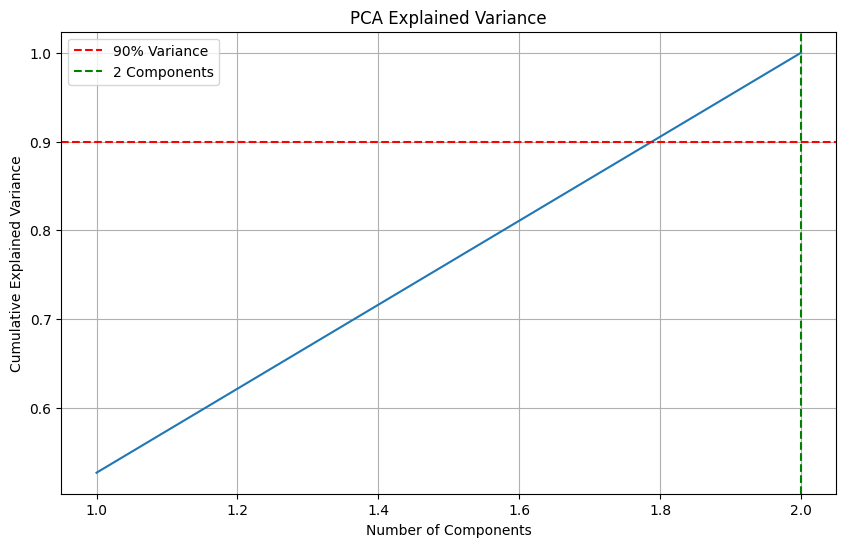

In [75]:

# Standardize data for PCA using only selected features
scaler = StandardScaler()
X_train_selected = X_train_features[selected_features]
X_val_selected = X_val_features[selected_features]
X_train_scaled = scaler.fit_transform(X_train_selected)
X_val_scaled = scaler.transform(X_val_selected)

# Apply PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# Find number of components for 90% variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
n_components_90 = np.argmax(cumulative_variance >= 0.9) + 1

print(f"Number of components for 90% variance: {n_components_90}")
print(f"Total variance explained by {n_components_90} components: {cumulative_variance[n_components_90-1]:.4f}")

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance')
plt.axvline(x=n_components_90, color='g', linestyle='--', label=f'{n_components_90} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

GridSearch


In [76]:
# Using selected features for tuning
X_train_selected = X_train_features[selected_features]
X_val_selected = X_val_features[selected_features]

# Hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'class_weight': [None, 'balanced'],
    'criterion': ['gini', 'entropy']
}

# NOTE:
# The previous run used parallel workers (n_jobs=-1) which can cause excessive memory usage
# and lead to TerminatedWorkerError on systems with limited RAM. To avoid worker crashes,
# run the search without parallel workers (n_jobs=1) and reduce n_iter. Increase these
# only if your environment has sufficient memory.
random_search = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=ERP_ID),
    param_grid,
    n_iter=20,            # reduce iterations to lower memory / time pressure
    cv=5,
    scoring='roc_auc',
    random_state=ERP_ID,
    n_jobs=1,             # avoid spawning parallel worker processes
    verbose=2
)

random_search.fit(X_train_selected, y_train)

print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=None, min_samples_leaf=5, min_samples_split=20; total time=   0.9s
[CV] END class_weight=balanced, criterion=entropy, max_depth=None, min_samples_leaf=5, min_samples_split=20; total time=   0.9s
[CV] END class_weight=balanced, criterion=entropy, max_depth=None, min_samples_leaf=5, min_samples_split=20; total time=   1.3s
[CV] END class_weight=balanced, criterion=entropy, max_depth=None, min_samples_leaf=5, min_samples_split=20; total time=   1.3s
[CV] END class_weight=balanced, criterion=entropy, max_depth=None, min_samples_leaf=5, min_samples_split=20; total time=   1.5s
[CV] END class_weight=balanced, criterion=entropy, max_depth=None, min_samples_leaf=5, min_samples_split=20; total time=   1.5s
[CV] END class_weight=balanced, criterion=entropy, max_depth=None, min_samples_leaf=5, min_samples_split=20; total time=   1.7s
[CV] END class_weight=balanced, criterion=

Model eval

Final AUROC on validation set: 0.5813

Top 10 Feature Importances:
         feature  importance
0      ps_car_13    0.772749
1  ps_ind_17_bin    0.227251


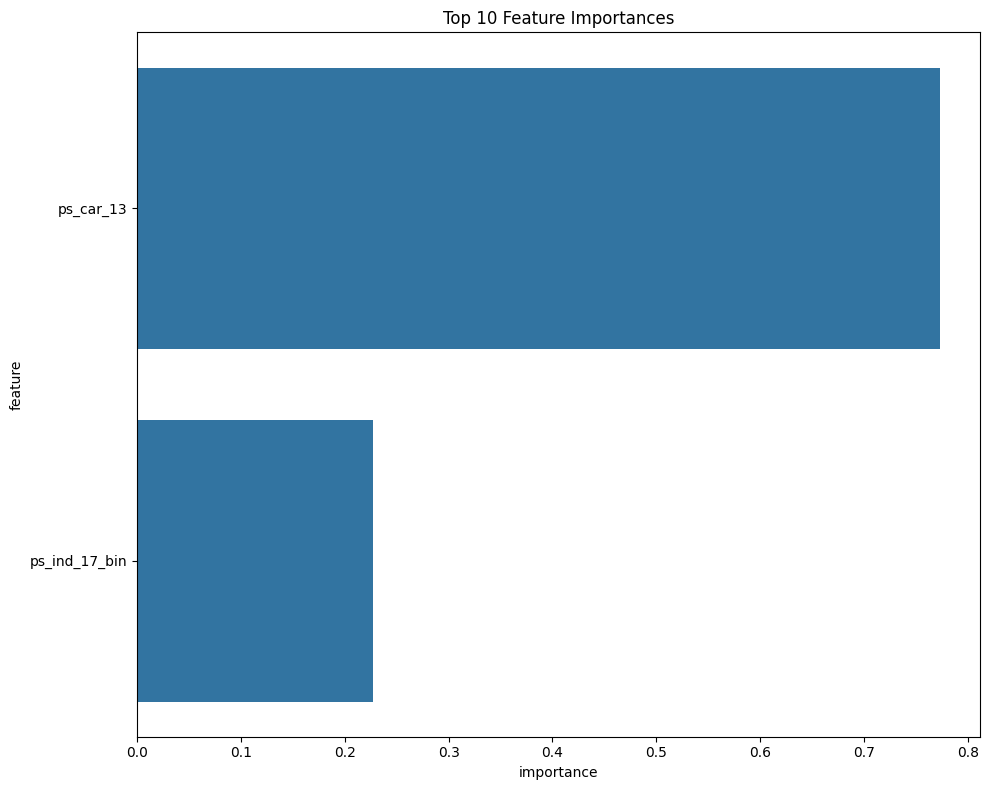

In [79]:
# Train final model with best parameters
best_dt = random_search.best_estimator_
y_pred_final = best_dt.predict_proba(X_val_selected)[:, 1]
final_auc = roc_auc_score(y_val, y_pred_final)

print(f"Final AUROC on validation set: {final_auc:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': best_dt.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Feature Importances:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

tracking progress!

In [81]:
# Build updated progress summary (ensure missing variables are defined)
# Use existing computed scores from the notebook
filter_auc = filter_score       # filter_score computed earlier
wrapper_auc = wrapper_score     # wrapper_score computed earlier

# Initial filter count: combine selected num and cat feature lists found earlier
initial_filter_count = len(selected_num_features) + len(selected_cat_features)

# Baseline features used (use X_train_features if available)
baseline_features_used = X_train_features.shape[1] if 'X_train_features' in globals() else (
    X_train_selected.shape[1] if 'X_train_selected' in globals() else None
)

progress_summary = {
    'Model Stage': ['Baseline', 'Filter Methods', 'Wrapper Methods', 'Hyperparameter Tuning'],
    'AUROC': [baseline_auc, filter_auc, wrapper_auc, final_auc],
    'Features Used': [baseline_features_used, initial_filter_count, len(selected_features), len(selected_features)]
}

progress_df = pd.DataFrame(progress_summary)
print("\nUpdated Progress Summary:")
print(progress_df)


Updated Progress Summary:
             Model Stage     AUROC  Features Used
0               Baseline  0.504306             65
1         Filter Methods  0.580384             30
2        Wrapper Methods  0.580384              2
3  Hyperparameter Tuning  0.581350              2
